In [1]:
import torch

epochs = 100
lr = 0.00001
train_batch_size = 32
test_batch_size = 1
ck_dir = 'checkpoint/best2'
device = torch.device('cuda:0')

In [2]:
TRAIN_PATH = './skin_leison/training'
TEST_PATH = './skin_leison/testing'

In [3]:
import cv2
import albumentations as A
from torch.utils.data import DataLoader

from dataset import Skin_Leison

train_transforms = [
    A.CLAHE(p=1),
    A.RandomRotate90(p=1),
    A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.ShiftScaleRotate(border_mode=cv2.BORDER_REFLECT, p=0.5, shift_limit=0, scale_limit=0.1, rotate_limit=10),
    ]

test_transforms = [A.CLAHE(p=1)]

trainset = Skin_Leison(TRAIN_PATH, transforms=train_transforms)
testset = Skin_Leison(TEST_PATH, transforms=test_transforms)
trainloader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=test_batch_size, num_workers=4)

In [4]:
from torch import nn
from torch.optim import Adam

from models.Unet import Unet

net = Unet(3, 1, 96, 6).to(device)
optimizer = Adam(net.parameters(), lr=lr)
criterion = nn.BCELoss()

In [5]:
from train import train

result = train(net, trainloader, testloader, epochs, optimizer, criterion, device=device, ck_dir=ck_dir)

Epoch: 0, Train Loss: 0.7161787700653075, Test Loss: 0.5894975173473359
Saving model to checkpoint/best2/check0.pt
Epoch: 1, Train Loss: 0.5390708208084107, Test Loss: 0.45103491827845593
val_loss improved from 0.5895 to 0.4510, saving model to checkpoint/best2/check1.pt
Epoch: 2, Train Loss: 0.4135048520565033, Test Loss: 0.37579945713281615
val_loss improved from 0.4510 to 0.3758, saving model to checkpoint/best2/check2.pt
Epoch: 3, Train Loss: 0.3249091422557831, Test Loss: 0.40984209552407275
Epoch: 4, Train Loss: 0.2760885125398635, Test Loss: 0.25732103966176506
val_loss improved from 0.3758 to 0.2573, saving model to checkpoint/best2/check4.pt
Epoch: 5, Train Loss: 0.24532278954982759, Test Loss: 0.23065231978893286
val_loss improved from 0.2573 to 0.2307, saving model to checkpoint/best2/check5.pt
Epoch: 6, Train Loss: 0.2299837028980255, Test Loss: 0.21679696995764963
val_loss improved from 0.2307 to 0.2168, saving model to checkpoint/best2/check6.pt
Epoch: 7, Train Loss: 0.21

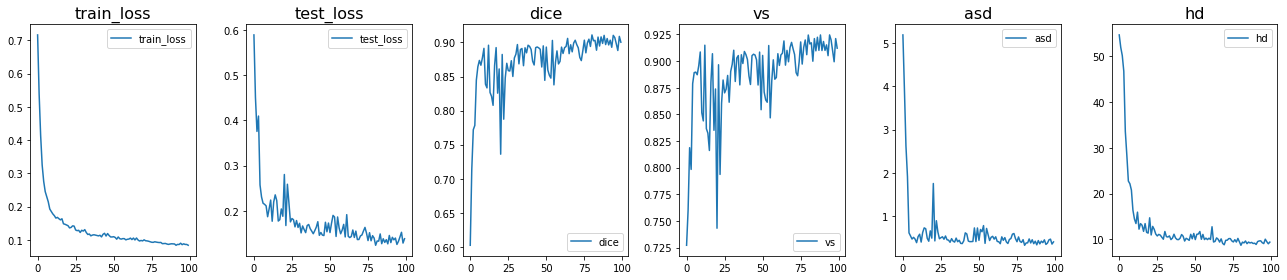

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18,4))
keys = ['train_loss', 'test_loss', 'dice', 'vs', 'asd', 'hd']
for i, (col, key) in enumerate(zip(axes, keys)):
    col.plot(range(len(result[key])), result[key], label=key)
    col.set_title(key, fontsize=16)
    col.legend()
fig.tight_layout()

In [7]:
import json
from pathlib import Path

json_path = Path(ck_dir)/'result.json'
json_path.parent.mkdir(parents=True, exist_ok=True)
with open(json_path, 'w') as fp:
    json.dump(result, fp, sort_keys=True, indent=4)